# Ecological Index - Values for Table 1 Historical Reconstruction
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- August 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# keep and convert tarea to km2 from cm2
tarea = ds_grid.TAREA/((100*100)*(1000*1000))

In [7]:
#  make temporary array with only ones for masks
mask_ones = np.ones([len(ds_grid.TLAT.nlat),len(ds_grid.TLAT.nlon)])
mask_ones = xr.DataArray(mask_ones,dims=('nlat','nlon'))
mask_ones['nlat'] = ds_grid.TLAT.nlat
mask_ones['nlon'] = ds_grid.TLAT.nlon

## Load the Present Day Ecoindex Data

In [8]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

In [9]:
file_in = 'ecoindex_present_day.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

In [10]:
ds_eco

<xarray.Dataset>
Dimensions:               (nlat: 36, nlon: 320)
Coordinates:
  * nlat                  (nlat) int64 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
  * nlon                  (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
    TLONG                 (nlat, nlon) float64 ...
    TLAT                  (nlat, nlon) float64 ...
Data variables:
    ecoindex_hemispheric  (nlat, nlon) float64 ...
    ecoindex_regional     (nlat, nlon) float64 ...
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-03
    contents:        Ecological Index - present day historical reconstruction.
    units:           Unitless

In [11]:
# keep both hemispheric and regional versions
eco_pd = ds_eco.ecoindex_regional
eco_hemi = ds_eco.ecoindex_hemispheric

# mask land
eco_pd = eco_pd.where(ds_grid.REGION_MASK == 1)
eco_hemi = eco_hemi.where(ds_grid.REGION_MASK == 1)

# mask where it's zero because that's out of SIZ
eco_pd = eco_pd.where(eco_pd > 0)
eco_hemi = eco_hemi.where(eco_hemi > 0)

## Load satellite polynya data for mask

In [12]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

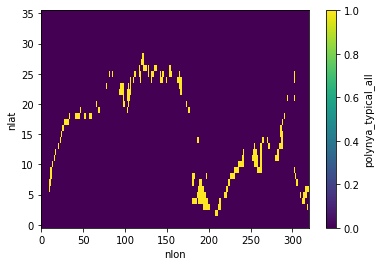

In [13]:
# Read in satellite polynya data
file_in = 'CESM_grid_SSMI_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_sat_pd = ds_poly.polynya_typical_all

# modify the mask for later calculations
poly_sat_pd = poly_sat_pd.fillna(0)

# test plot
poly_sat_pd.plot()

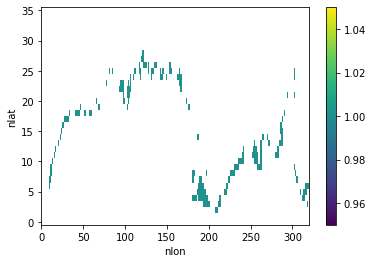

In [14]:
poly_mask = mask_ones.where(poly_sat_pd > 0.0)
poly_mask.plot()

## Load CCAMLR regions for masks

In [15]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [16]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v9_02062025.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

In [17]:
# keep just masks of interest (MPAs, MPA planning areas)
ccamlr_in = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9',
             'Ross_mpa','Weddell_mpa','Weddell_mpa_2','Ant_Peninsula_mpa','East_Ant_mpa']
ccamlr_masks = ds_ccamlr[ccamlr_in]

In [18]:
# mask of all mpas around whole continent
tmp1 = ccamlr_masks.Ross_mpa.fillna(0)
tmp2 = ccamlr_masks.Weddell_mpa.fillna(0)
tmp3 = ccamlr_masks.Weddell_mpa_2.fillna(0)
tmp4 = ccamlr_masks.Ant_Peninsula_mpa.fillna(0)
tmp5 = ccamlr_masks.East_Ant_mpa.fillna(0)

# add all together
tmp0 = tmp1 + tmp2 + tmp3 + tmp4 + tmp5

# create mask of the mpas
mpa_all = mask_ones.where(tmp0 > 0.0)

In [19]:
# now make xarray with all relevant masks as a new coordinate
ccamlr_all = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9', 'All_mpa']

ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod,
                          ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9, mpa_all],
                         dim='region')
ccamlr_masks['region'] = ccamlr_all

## Load AEV Binned Data for masks

In [20]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

In [21]:
file_in = 'ecoindex_present_day_bins.nc'
ds_bin = xr.open_dataset(path_in+file_in, decode_times=True)

In [22]:
# save the bin data
bins_region = ds_bin.aev_bins_region
bins_hemi = ds_bin.aev_bins_hemi

In [23]:
# combine regional data into a single array for all three bins
data = bins_region

# load the three bins, set missing values to zero
tmp1 = data.isel(bin=0).fillna(0)
tmp2 = data.isel(bin=1).fillna(0)
tmp3 = data.isel(bin=2).fillna(0)

# for each of the three bins, re-label so that bin values are 1, 2, 3 and 0 is "other"
tmp1 = tmp1.where(tmp1 == 0, 3)
tmp2 = tmp2.where(tmp2 == 0, 2)

# add all three together
tmp0 = tmp1 + tmp2 + tmp3

# mask by where we have data or not
tmp0 = tmp0.where(ds_grid.REGION_MASK == 1)

# create mask of the high value points
bins_all = mask_ones.where(tmp0 > 0.0)
#bins_all.plot()

# now make xarray with all relevant masks as a new coordinate
bin_names = ['5pct','10pct','25pct','all']
bin_masks = xr.concat([data.isel(bin=0),data.isel(bin=1),data.isel(bin=2),bins_all], dim = 'bins')
bin_masks['bins'] = bin_names

# assign this info
bin_mask_regions = bin_masks

In [24]:
# combine regional data into a single array for all three bins
data = bins_hemi

# load the three bins, set missing values to zero
tmp1 = data.isel(bin=0).fillna(0)
tmp2 = data.isel(bin=1).fillna(0)
tmp3 = data.isel(bin=2).fillna(0)

# for each of the three bins, re-label so that bin values are 1, 2, 3 and 0 is "other"
tmp1 = tmp1.where(tmp1 == 0, 3)
tmp2 = tmp2.where(tmp2 == 0, 2)

# add all three together
tmp0 = tmp1 + tmp2 + tmp3

# mask by where we have data or not
tmp0 = tmp0.where(ds_grid.REGION_MASK == 1)

# create mask of the high value points
bins_all = mask_ones.where(tmp0 > 0.0)
#bins_all.plot()

# now make xarray with all relevant masks as a new coordinate
bin_names = ['5pct','10pct','25pct','all']
bin_masks = xr.concat([data.isel(bin=0),data.isel(bin=1),data.isel(bin=2),bins_all], dim = 'bins')
bin_masks['bins'] = bin_names

# assign this info
bin_mask_hemi = bin_masks

# Calculate stats for Table 1
- 4 zones: whole region, in polynyas, outside polynyas, in mpas
- 4 bin groups: all bins, bin 1, bin 2, bin 3
- Calculate area weighted average - SUM(TAREA * data)/SUM(TAREA)
- Calculate areaweighted standard deviation - https://www.statology.org/weighted-standard-deviation-excel/

## Hemispheric

In [25]:
# set AEV data to use
data_calc = eco_hemi
bin_mask = bin_mask_hemi
label = 'Hemispheric'
mpa = 'All_mpa'

In [26]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [27]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Hemispheric fraction total area that is also:
polynyas
4.273653804152298
mpas
28.759131427402814


In [28]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Hemispheric area weighted average AEV Index values:
avg overall
0.2796010507350853
avg IN polynya
0.4274682077619588
avg OUT polynya
0.2729995970783855


In [29]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Hemispheric standard deviation AEV Index values:
std overall
0.09357076504095148
std IN polynya
0.22892055831760727
std OUT polynya
0.08254590120234652


In [30]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Hemispheric values of percent of area for bin all:
Percent total area
25.293618530009425
Percent total area IN polynyas
3.20536596661716
Percent total area IN MPAs
13.784706968452895


In [31]:
# calculate fractions of total areas
n = 0
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Hemispheric values of percent of area for bin 5pct:
Percent total area
3.8106093155252223
Percent total area IN polynyas
1.3442094398224624
Percent total area IN MPAs
3.0920063150040975


In [32]:
# calculate fractions of total areas
n = 1
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Hemispheric values of percent of area for bin 10pct:
Percent total area
4.745948041279948
Percent total area IN polynyas
0.8907909404677844
Percent total area IN MPAs
2.819900495909755


In [33]:
# calculate fractions of total areas
n = 2
name = bin_names[n]
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1))
pct_total = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in polynyas *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# in MPAs *AND* this bin
tmp = tarea_eco.where((data_calc > 0) & (bin_mask.isel(bins=n) == 1) & (ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/tarea_eco.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Hemispheric values of percent of area for bin 25pct:
Percent total area
16.737061173204264
Percent total area IN polynyas
0.9703655863269138
Percent total area IN MPAs
7.872800157539044


## Regions

In [34]:
# set regional data to use
data_calc = eco_pd
bin_mask = bin_mask_regions

# mask TAREA for each region
tarea_eco = tarea.where((data_calc > 0) & (ccamlr_masks == 1))
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1) & (ccamlr_masks == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0) & (ccamlr_masks == 1))

### Weddell Sea

In [35]:
# set regional data to use
label = 'Weddell'
reg = 'mpa_plan_3_4'
mpa = 'All_mpa'

In [36]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Weddell fraction total area that is also:
polynyas
2.955107335945788
mpas
43.02927256194603


In [37]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Weddell area weighted average AEV Index values:
avg overall
0.3798591914172352
avg IN polynya
0.5232337602821993
avg OUT polynya
0.37549330230540306


In [38]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Weddell standard deviation AEV Index values:
std overall
0.07402968766181629
std IN polynya
0.23542919810410018
std OUT polynya
0.0631594554535011


In [39]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin all:
Percent total area
22.572230642825016
Percent total area IN polynyas
8.328351187684529
Percent total area IN MPAs
79.0040394346154


In [40]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 5pct:
Percent total area
3.9039736463917687
Percent total area IN polynyas
38.23447777442816
Percent total area IN MPAs
100.0


In [41]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 10pct:
Percent total area
3.9413038905086863
Percent total area IN polynyas
6.508919566934838
Percent total area IN MPAs
93.90380429018143


In [42]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Weddell values of percent of area for bin 25pct:
Percent total area
14.726953105924562
Percent total area IN polynyas
0.88745038853389
Percent total area IN MPAs
69.45065952575634


### East Antarctica

In [43]:
# set regional data to use
label = 'EAntarctica'
reg = 'mpa_plan_7_mod'
mpa = 'All_mpa'

In [44]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

EAntarctica fraction total area that is also:
polynyas
6.741323739933873
mpas
22.056264126326862


In [45]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

EAntarctica area weighted average AEV Index values:
avg overall
0.4477180391332801
avg IN polynya
0.6172150092170424
avg OUT polynya
0.4354657319582767


In [46]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

EAntarctica standard deviation AEV Index values:
std overall
0.10107580240972344
std IN polynya
0.24428464576992537
std OUT polynya
0.08174798635173205


In [47]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin all:
Percent total area
22.521130209639587
Percent total area IN polynyas
24.083079309571517
Percent total area IN MPAs
45.78046045015425


In [48]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 5pct:
Percent total area
4.205452797151531
Percent total area IN polynyas
58.740560591332844
Percent total area IN MPAs
55.00799909556701


In [49]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 10pct:
Percent total area
4.6127726581260955
Percent total area IN polynyas
24.124002072350322
Percent total area IN MPAs
35.49471158617321


In [50]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

EAntarctica values of percent of area for bin 25pct:
Percent total area
13.702904754361962
Percent total area IN polynyas
13.432843347492373
Percent total area IN MPAs
46.41097223402973


### Ross Sea

In [51]:
# set regional data to use
label = 'Ross'
reg = 'mpa_plan_8'
mpa = 'All_mpa'

In [52]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Ross fraction total area that is also:
polynyas
3.55086830913284
mpas
38.1600140020325


In [53]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Ross area weighted average AEV Index values:
avg overall
0.360687925443189
avg IN polynya
0.7305628072328891
avg OUT polynya
0.3470706230054557


In [54]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Ross standard deviation AEV Index values:
std overall
0.1477954404454058
std IN polynya
0.41597366453710544
std OUT polynya
0.12790418011011262


In [55]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin all:
Percent total area
20.185292984684974
Percent total area IN polynyas
15.880060989100661
Percent total area IN MPAs
78.43837237131245


In [56]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 5pct:
Percent total area
3.670708933600681
Percent total area IN polynyas
45.507383101358656
Percent total area IN MPAs
97.26050761873337


In [57]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 10pct:
Percent total area
3.563843995549878
Percent total area IN polynyas
25.66727929947536
Percent total area IN MPAs
84.9820508788582


In [58]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Ross values of percent of area for bin 25pct:
Percent total area
12.950740055534418
Percent total area IN polynyas
4.789312927694371
Percent total area IN MPAs
71.30277788298181


### Amundsen Sea

In [59]:
# set regional data to use
label = 'Amundsen'
reg = 'mpa_plan_9'
mpa = 'All_mpa'

In [60]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

Amundsen fraction total area that is also:
polynyas
4.849131904090945
mpas
0.0


In [61]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Amundsen area weighted average AEV Index values:
avg overall
0.36463440993885
avg IN polynya
0.5195537275275912
avg OUT polynya
0.3567393247913099


In [62]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

Amundsen standard deviation AEV Index values:
std overall
0.09128020690379583
std IN polynya
0.24429496174175
std OUT polynya
0.0758873098719843


In [63]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin all:
Percent total area
25.31450450582992
Percent total area IN polynyas
12.782866991418922
Percent total area IN MPAs
0.0


In [64]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 5pct:
Percent total area
3.929901311768677
Percent total area IN polynyas
52.119551229286145
Percent total area IN MPAs
0.0


In [65]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 10pct:
Percent total area
5.014643413525403
Percent total area IN polynyas
7.598091336160024
Percent total area IN MPAs
0.0


In [66]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

Amundsen values of percent of area for bin 25pct:
Percent total area
16.36995978053584
Percent total area IN polynyas
4.927656128306796
Percent total area IN MPAs
0.0


### Antarctic Peninsula

In [67]:
# set regional data to use
label = 'AntPeninsula'
reg = 'mpa_plan_1_mod'
mpa = 'All_mpa'

In [68]:
# get total area within this zone that is in polynyas and MPAs

# % area that's polynyas
poly_frac = tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# % area that's in MPAs
mpa_frac = tarea_eco.sel(region=reg).where(ccamlr_masks.sel(region=mpa) == 1).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])

# print values
print(label + ' fraction total area that is also:')
print('polynyas')
print(100 * poly_frac.values)
print('mpas')
print(100 * mpa_frac.values)

AntPeninsula fraction total area that is also:
polynyas
2.3795483806580604
mpas
36.274226004761005


In [69]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly.sel(region=reg)*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"]))

# print values
print(label + ' area weighted average AEV Index values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

AntPeninsula area weighted average AEV Index values:
avg overall
0.31703283829743817
avg IN polynya
0.5170854839947551
avg OUT polynya
0.3121564528554649


In [70]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly.sel(region=reg)*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.sel(region=reg).stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sel(region=reg).sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

# print values
print(label + ' standard deviation AEV Index values:')
print('std overall')
print(std.values)
print('std IN polynya')
print(poly_std.values)
print('std OUT polynya')
print(nopoly_std.values)

AntPeninsula standard deviation AEV Index values:
std overall
0.11771582750879507
std IN polynya
0.2900303078440639
std OUT polynya
0.11057942684009196


In [71]:
# calculate fractions of total areas
n = 3 # bin with all three values
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin all:
Percent total area
27.494503974120875
Percent total area IN polynyas
7.0536529968875366
Percent total area IN MPAs
52.72494010946558


In [72]:
# calculate fractions of total areas
n = 0
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 5pct:
Percent total area
5.010824648067965
Percent total area IN polynyas
14.829087541147285
Percent total area IN MPAs
93.74049438942173


In [73]:
# calculate fractions of total areas
n = 1
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 10pct:
Percent total area
5.13332029681329
Percent total area IN polynyas
11.413392384565807
Percent total area IN MPAs
66.73005809330336


In [74]:
# calculate fractions of total areas
n = 2
name = bin_names[n]

# percent of total area that is in this bin
data_tmp = tarea_eco.sel(region=reg)
tmp = data_tmp.where(bin_mask.isel(bins=n) == 1)
pct_total = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in polynyas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((poly_mask == 1))
pct_total_poly = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# percent of total area in this bin that is ALSO in mpas
data_tmp = tarea_eco.sel(region=reg).where(bin_mask.isel(bins=n) == 1)
tmp = data_tmp.where((ccamlr_masks.sel(region=mpa) == 1))
pct_total_mpa = tmp.sum(dim=['nlat','nlon'])/data_tmp.sum(dim=['nlat','nlon'])

# print values
print(label + ' values of percent of area for bin '+name+':')
print('Percent total area')
print(100 * pct_total.values)
print('Percent total area IN polynyas')
print(100 * pct_total_poly.values)
print('Percent total area IN MPAs')
print(100 * pct_total_mpa.values)

AntPeninsula values of percent of area for bin 25pct:
Percent total area
17.350359029239616
Percent total area IN polynyas
3.518205825562385
Percent total area IN MPAs
36.73596222846835
